<a href="https://colab.research.google.com/github/noumanjavaid96/datasetss/blob/main/Another_copy_of_PDF_Files.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API - read a PDF

This notebook demonstrates how you can convert a PDF file so that it can be read by the Gemini API.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/PDF_Files.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Setup

In [48]:
!pip install -Uq google-generativeai

In [ ]:
import google.generativeai as genai


import pathlib
import tqdm
import os

In [ ]:
from google.colab import userdata
userdata.get('secretName')

'id=mnjavaid96@gmail.com?Password=Hulkyman@123'

In [ ]:
from google.colab import userdata
genai.configure(api_key=userdata.get("GOOGLE_API_KEY"))

Install the PDF processing tools:

In [ ]:
!apt install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.4).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


## Download and proces the PDF

This textbook is from OpenStax, it's License is Commons Attribution License v4.0. More detrails are [available on the site](https://openstax.org/details/books/university-physics-volume-2).

In [ ]:
import pathlib

In [ ]:
if not pathlib.Path('/content/my.pdf').exists():
    !get my.pdf

In [ ]:
!open '/content/my.pdf'

/usr/bin/open: 882: www-browser: not found
/usr/bin/open: 882: links2: not found
/usr/bin/open: 882: elinks: not found
/usr/bin/open: 882: links: not found
/usr/bin/open: 882: lynx: not found
/usr/bin/open: 882: w3m: not found
xdg-open: no method available for opening '/content/my.pdf'


In [ ]:
!file '/content/my.pdf'

/content/my.pdf: PDF document, version 1.7 (zip deflate encoded)


You'll extract Chapter 3, pages [121-154].

In [ ]:
first = 1
last = 196

In [ ]:
!mkdir output
 # extract images of Chapter 3
!pdftoppm my.pdf -f {first} -l {last} output/images -jpeg

mkdir: cannot create directory ‘output’: File exists


Look at the first image, scaled down:

In [ ]:
import PIL.Image

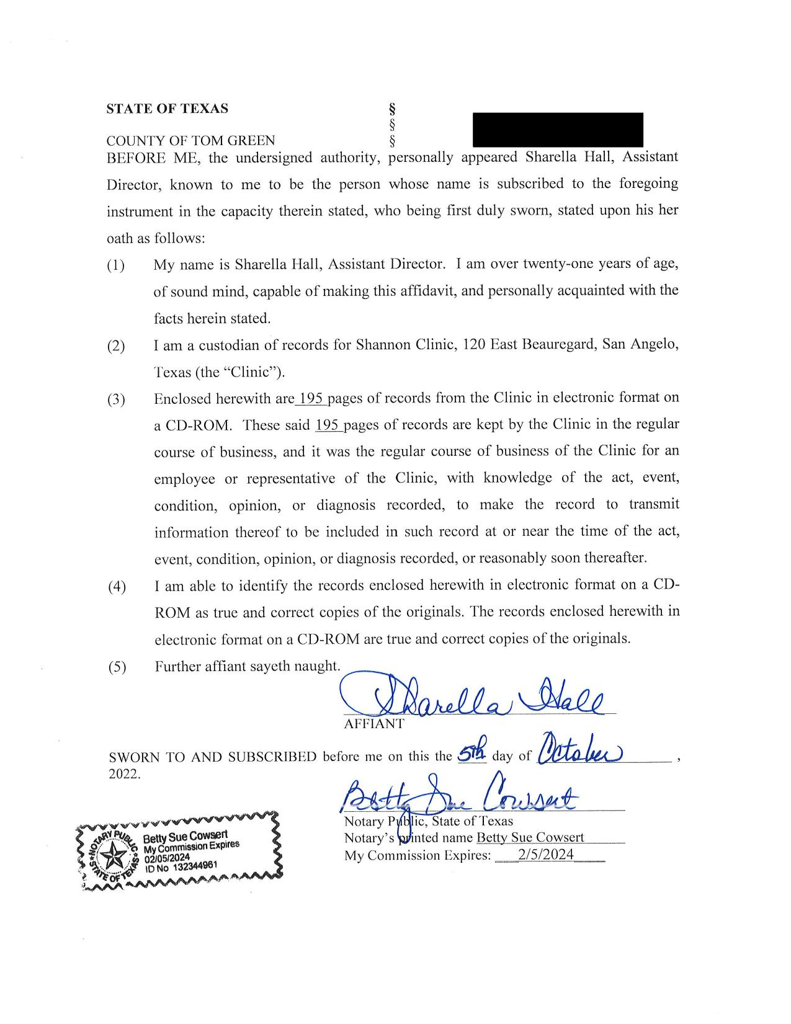

In [ ]:
img = PIL.Image.open(f"output/images-001.jpg")
img.thumbnail([1024, 1024])
img

Extract the text for thopse same pages.

In [ ]:
!pdftotext my.pdf

In [ ]:
import google.generativeai as genai


import pathlib
import tqdm
import os

In [ ]:
for page_number in range(first,last+1):
  page_number = f"{page_number:03d}"
  ! pdftotext  my.pdf -f {page_number} -l {page_number}
  ! mv my.txt output/text-{page_number}.txt

In [ ]:
!ls output

images-001.jpg	images-067.jpg	images-133.jpg	text-003.txt  text-069.txt  text-135.txt
images-002.jpg	images-068.jpg	images-134.jpg	text-004.txt  text-070.txt  text-136.txt
images-003.jpg	images-069.jpg	images-135.jpg	text-005.txt  text-071.txt  text-137.txt
images-004.jpg	images-070.jpg	images-136.jpg	text-006.txt  text-072.txt  text-138.txt
images-005.jpg	images-071.jpg	images-137.jpg	text-007.txt  text-073.txt  text-139.txt
images-006.jpg	images-072.jpg	images-138.jpg	text-008.txt  text-074.txt  text-140.txt
images-007.jpg	images-073.jpg	images-139.jpg	text-009.txt  text-075.txt  text-141.txt
images-008.jpg	images-074.jpg	images-140.jpg	text-010.txt  text-076.txt  text-142.txt
images-009.jpg	images-075.jpg	images-141.jpg	text-011.txt  text-077.txt  text-143.txt
images-010.jpg	images-076.jpg	images-142.jpg	text-012.txt  text-078.txt  text-144.txt
images-011.jpg	images-077.jpg	images-143.jpg	text-013.txt  text-079.txt  text-145.txt
images-012.jpg	images-078.jpg	images-144.jpg	text-014.

In [ ]:
!cat output/text-001.txt

## Assemble the files into a prompt

Upload all the files usng the files API, there are too many to send with the `generate_content` request.

In [ ]:
files = []
image_files = list(pathlib.Path("output").glob('images-*.jpg'))
for img in tqdm.tqdm(image_files):
    files.append(genai.upload_file(img))

100%|██████████| 196/196 [08:05<00:00,  2.48s/it]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load all the texts:

In [ ]:
texts = [t.read_text() for t in pathlib.Path("output").glob('text-*.txt')]

Interleave the page-numbers, texts, and image-file references:

In [ ]:
textbook = []
for page, (text, image) in enumerate(zip(texts, files)):
  textbook.append(f'## Page {first+page} ##')
  textbook.append(text)
  textbook.append(image)

## Try it out

In [38]:
model = genai.GenerativeModel(model_name='gemini-1.5-pro-latest')

In [46]:
response = model.generate_content(
    ['''#A detailed Medical Report of 195 pages you need to create a Analysis Document which must be assessed according to criteria and all the information needs to be presented with reference from pages as well:
      [START]''']+
    textbook +
    ["""[END]\n\n
     Key Steps:
• **Collect Records:** Gather documents received at various times from multiple sources. (include reference)
• **Review and Enter Information:** Analyze the records to document important details such as:
                            ▪ Date of First Treatment: The initial treatment date as recorded. (include reference)
                            ▪ Contact Date: When the patient or provider first made contact. (include reference)
                            ▪ Healthcare Providers: The names of involved medical professionals (physicians, PAs, nurses, etc.). (include reference)
                            ▪ Chief Complaint: The main reason for the healthcare visit (symptoms, concerns). (include reference)
                            ▪ Treatment Details: Overview of provided interventions (hospital stays, X-rays, CT scans, MRI, social worker visits) and their purposes.(include reference)
                            ▪ Diagnosis and Assessment: Visit outcomes, including diagnoses. (include reference)
▪ Follow-Up Care: Prescribed treatments and recommended actions."""]
)

In [47]:
from IPython.display import Markdown
Markdown(response.text)

## Analysis of Medical Records for Penelope Bethann Killingsworth 

This document analyzes the provided 195-page medical record for Penelope Bethann Killingsworth, focusing on key details relevant to her medical history. 

**Patient Demographics:**

* **Name:** Penelope Bethann Killingsworth 
* **MRN:** 20081938
* **DOB:** 5/11/2016
* **Sex:** Female 

**Active Coverages:**

* **Insurance:** BLUE CROSS BLUE SHIELD OF TEXAS (Effective 7/25/2017) (Page 1)

**Care Team:**

* **Primary Care Physician (PCP):** Michael A. Wagnon, DO (Pediatrics) (Page 1)

**Problem List:**

* **Attention Deficit Hyperactivity Disorder, Combined Type:** Diagnosed on 04/01/2022 (Page 1). 
    * This diagnosis is noted as both chronic (Page 1) and not chronic (Page 1) in separate entries. This discrepancy needs clarification.
* **Familial Short Stature:** Noted on 11/15/2017 (Page 1).
* **Insect Bite Reaction (Initial):** Noted on 05/12/2020 (Page 1).
* **Posttraumatic Stress Disorder:** Noted on 05/13/2022, potentially related to child abuse. The case is noted as "Trial Pending" (Page 1). 
* **Seasonal Allergic Rhinitis:** Noted on 05/12/2020 (Page 1). 

**Date of First Treatment:**

* The earliest recorded treatment date is 07/13/2016 for DTaP/Hep B/IPV vaccination. (Page 14)

**Contact Date:**

* It's unclear when the initial contact occurred, but the earliest documented visit is on 07/13/2016 for vaccinations. (Page 14)

**Healthcare Providers:**

* **Physicians:**
    * Michael A. Wagnon, DO (PCP)
    * Elizabeth Lee Young, MD 
    * R. Douglas Schultz, MD
    * Scott K. Ross, MD
    * Sanjay S. Patel, MD
    * Kathleen Cubine, DO
* **Physician Assistant:**
    * Julie A. Green, PA
* **Nurses:**
    * Stefany Holik, RN
    * Lauren M Webster, RN
    * Sharon Ra Nae Chapman, RN
* **Nurse Practitioner:**
    * Deborah L. Hagelstein, APRN FNP
* **Medical Assistants:**
    * Kyla Garcia 
    * Paris Crisp, MA
    * Nelida Huerta-Medina, CMA
    * Maddie Oliver, RMA
    * Jacqueline Guerrero, CNA
    * Mary Lou Castillo, MA
    * Ashley Fernandez, MA
    * Harold Bunda, RN

**Chief Complaints:**

* **04/06/2021:** Follow-up (evaluation) for possible injury to right arm and chest, facial pain, and right forearm pain. Concerns were raised about the force involved in the potential injury. (Page 168, 169)
* **05/13/2021:** 5-year well-child checkup. No specific concerns noted. (Page 110) 
* **08/04/2021:** COVID-19 testing (Page 105).
* **04/01/2022:** ADD evaluation (Page 72).
* **04/27/2022:**  ADD medication recheck. Right ear pain for two days. (Page 50)
* **05/13/2022:** 6-year well-child checkup. No specific concerns noted. (Page 22)

**Treatment Details:**

* **Vaccinations:** Routine childhood vaccinations administered on various dates, including DTaP, Hep B, IPV, Hib, MMRV, Pneumococcal, and Rotavirus. (Pages 5-8, 14)
* **X-Rays (04/06/2021):** Multiple X-rays were ordered due to suspected injury.  
    * Right and left shoulder (Pages 147, 149)
    * Right and left humerus (Pages 154, 155) 
    * Right and left wrist (Pages 156, 158) 
    * Chest (Page 150)
    * Ribs (Page 152)
    * Pelvis (Page 142)
    * Right and left tibia and fibula (Pages 165, 164)
    * Right and left femur (Pages 163, 162) 
    * **Purpose:** To rule out fractures or other bone abnormalities.
    * **Results:** All X-ray reports were normal. (Pages 147-167)
* **Lab Tests (04/06/2021):** CBC, Protime-INR, and PTT were initially ordered but declined by the parents. These tests were likely ordered to assess for bleeding or clotting issues related to the potential injury. (Page 178)
* **COVID-19 Test (08/04/2021):** SARS antigen FIA test performed. Result was negative. (Page 107)
* **ADHD Medication:** 
    * **04/01/2022:** Amphetamine-dextroamphetamine XR (Adderall XR) 5 mg prescribed. (Page 72)
    * **04/27/2022:** Dose increased to 10 mg. (Page 54)
    * **05/13/2022:** Continue on 10 mg dose. (Page 27) 
* **Play Therapy:** Penelope began play therapy in May 2021 with Brooke at West Texas Counseling (WTCG) to address emotional concerns and potential PTSD/anxiety. (Page 73)

**Diagnosis and Assessment:**

* **04/06/2021:**  Injury to the right and left upper extremities and a finding related to bruising.  (Page 168).  No evidence of fracture or other injury found on X-rays. Lab work declined by parents.
* **05/13/2021:** 5-year well-child checkup. Normal growth and development. Visual acuity screening noted as abnormal. (Page 114)
* **08/04/2021:** Negative for COVID-19. (Page 107)
* **04/01/2022:** Attention deficit hyperactivity disorder, combined type. (Page 72)
* **04/27/2022:** Attention deficit hyperactivity disorder, combined type. (Page 50)
* **05/13/2022:** 6-year well-child checkup. Normal growth and development. Posttraumatic stress disorder related to child abuse. (Page 22) 

**Follow-Up Care:**

* **04/06/2021:** Return if symptoms worsen. (Page 168)
* **05/13/2021:** Follow-up for 6-year well-child checkup as needed. (Page 115)
* **04/01/2022:** Recheck in a few weeks to monitor ADHD medication response.  (Page 77)
* **04/27/2022:** Follow-up in 6 months for ADHD medication recheck. (Page 54)
* **05/13/2022:**  Return if symptoms worsen or fail to improve.  Follow-up as needed and next childhood checkup. (Page 22)

**Additional Notes:**

* There is a mention of a potential child abuse incident at Penelope's school in February/March 2021. The incident involved allegations of injury by a teacher, and Penelope was interviewed at the Children's Advocacy Center (CAC) and by a detective. (Pages 169, 170). This incident is likely related to her recent diagnosis of Posttraumatic Stress Disorder.
* Penelope was switched to home schooling in January 2022 due to difficulty focusing and following directions. (Page 74)
* Extensive counseling and history review were conducted during the visits on 04/01/2022 and 04/06/2021. (Pages 169, 77)
* Penelope's mother reported possible anxiety related to the child abuse incident. (Page 171).
* The Vanderbilt assessment scales provided valuable information about Penelope's behavior in different settings (Pages 93-100). 

**Recommendations:**

* Clarification is needed regarding the conflicting documentation of Attention Deficit Hyperactivity Disorder as both chronic and not chronic. 
* Close monitoring of Penelope's response to ADHD medication, including side effects, is crucial.
* Continued play therapy to address the emotional impact of the alleged child abuse incident is vital. 
* Addressing Penelope's mother's anxiety related to the child abuse incident may also be beneficial.

This analysis provides a comprehensive summary of Penelope's medical history based on the provided records. It highlights key details relevant to her care and offers recommendations for further investigation and management.  Please note that this analysis is based solely on the information provided and may require further clarification from the treating healthcare providers. 
